In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

In [2]:
data_dir = '../TensorFlow-Bootcamp/04-Recurrent-Neural-Networks/word2vec_data/words'
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [3]:
def fetch_words_data(url=data_url, words_data=data_dir):
    os.makedirs(words_data, exist_ok=True)
    zip_path = os.path.join(words_data, "words.zip")
    
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)

    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])

    return data.decode("ascii").split()

In [4]:
words = fetch_words_data()

In [5]:
len(words)

17005207

In [6]:
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [7]:
for w in words[9000:9040]:
    print(w, end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

In [8]:
from collections import Counter

In [9]:
def create_counts(vocab_size=50000):
    vocab = [] + Counter(words).most_common(vocab_size)
    vocab = np.array([word for word, _ in vocab])
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    
    return data, vocab

In [10]:
data, vocabulary = create_counts()

In [12]:
data.shape

(17005207,)

In [13]:
vocabulary.shape

(50000,)

In [14]:
words[100]

'interpretations'

In [15]:
data[100]

4186

In [16]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    
    if data_index + span > len(data):
        data_index = 0
    
    buffer.extend(data[data_index: data_index + span])
    data_index += span
    
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
    
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [18]:
# Constants
batch_size = 128
embed_size = 150
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64
learn_rate = .01
vocabulary_size = 50000

In [19]:
# Placeholders
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [20]:
# Variables
init_embeds = tf.random_uniform([vocabulary_size, embed_size], -1.0, 1.0)
embeds = tf.Variable(init_embeds)
embed = tf.nn.embedding_lookup(embeds, train_inputs)

In [23]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embed_size], 
                                              stddev=1.0 / np.sqrt(embed_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [24]:
loss = tf.reduce_mean(tf.nn.nce_loss(
    nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [26]:
# Compute cosine similarity between minibatch examples and all embeddings
norm = tf.sqrt(tf.reduce_sum(tf.square(embeds), axis=1, keep_dims=True))
normalized_embeddings = embeds / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [27]:
data_index = 0
init= tf.global_variables_initializer()

In [32]:
num_steps = 5000

with tf.Session() as s:
    s.run(init)
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = s.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 10 == 0:
            if step > 0:
                average_loss = average_loss / 10
            print("Average loss at step ", step, " is: ", average_loss)
            average_loss = 0
        
        final_embeds = normalized_embeddings.eval()

Average loss at step  0  is:  242.83328247070312
Average loss at step  10  is:  387.75258483886716
Average loss at step  20  is:  726.5169647216796
Average loss at step  30  is:  457.17034606933595
Average loss at step  40  is:  1288.886050415039
Average loss at step  50  is:  1103.762368774414
Average loss at step  60  is:  1876.9170227050781
Average loss at step  70  is:  756.4308288574218
Average loss at step  80  is:  2232.624871826172
Average loss at step  90  is:  691.5992736816406
Average loss at step  100  is:  1178.1671905517578
Average loss at step  110  is:  3563.2169189453125
Average loss at step  120  is:  2978.683947753906
Average loss at step  130  is:  4284.014245605469
Average loss at step  140  is:  3234.2283142089846
Average loss at step  150  is:  1429.2615600585937
Average loss at step  160  is:  4196.547036743164
Average loss at step  170  is:  2666.6318481445314
Average loss at step  180  is:  5995.9802917480465
Average loss at step  190  is:  5422.637432861328
A

Average loss at step  1620  is:  23923.159423828125
Average loss at step  1630  is:  19766.161352539064
Average loss at step  1640  is:  24418.487927246093
Average loss at step  1650  is:  20364.996472167968
Average loss at step  1660  is:  22895.296337890624
Average loss at step  1670  is:  15937.48173828125
Average loss at step  1680  is:  23170.06591796875
Average loss at step  1690  is:  18360.029052734375
Average loss at step  1700  is:  10918.985028076171
Average loss at step  1710  is:  24137.028686523438
Average loss at step  1720  is:  21290.995031738283
Average loss at step  1730  is:  30902.33056640625
Average loss at step  1740  is:  23591.603759765625
Average loss at step  1750  is:  38194.20954589844
Average loss at step  1760  is:  29426.25354614258
Average loss at step  1770  is:  22284.722314453124
Average loss at step  1780  is:  25848.722108840942
Average loss at step  1790  is:  23031.217517089844
Average loss at step  1800  is:  8332.6
Average loss at step  1810  i

Average loss at step  3220  is:  42488.16254882813
Average loss at step  3230  is:  14894.800634765625
Average loss at step  3240  is:  24285.391479492188
Average loss at step  3250  is:  23842.63801269531
Average loss at step  3260  is:  26465.31286010742
Average loss at step  3270  is:  35158.767846679686
Average loss at step  3280  is:  29074.65817871094
Average loss at step  3290  is:  29885.131787109374
Average loss at step  3300  is:  20184.98974609375
Average loss at step  3310  is:  43581.64975585938
Average loss at step  3320  is:  41261.24169921875
Average loss at step  3330  is:  25455.276483154295
Average loss at step  3340  is:  17424.94729003906
Average loss at step  3350  is:  31424.6453125
Average loss at step  3360  is:  43583.16973876953
Average loss at step  3370  is:  34686.578186035156
Average loss at step  3380  is:  18099.472576904296
Average loss at step  3390  is:  27417.476818847656
Average loss at step  3400  is:  82583.34953613281
Average loss at step  3410 

Average loss at step  4830  is:  34748.91635742188
Average loss at step  4840  is:  32038.444299316405
Average loss at step  4850  is:  32919.36169433594
Average loss at step  4860  is:  61236.1203125
Average loss at step  4870  is:  42695.176025390625
Average loss at step  4880  is:  45915.891015625
Average loss at step  4890  is:  37770.61184082031
Average loss at step  4900  is:  49438.12097167969
Average loss at step  4910  is:  33273.441162109375
Average loss at step  4920  is:  58341.96437988281
Average loss at step  4930  is:  29024.2103515625
Average loss at step  4940  is:  58837.71328125
Average loss at step  4950  is:  50340.937890625
Average loss at step  4960  is:  49560.06209716797
Average loss at step  4970  is:  43489.866015625
Average loss at step  4980  is:  18945.46746826172
Average loss at step  4990  is:  23401.83448486328


In [33]:
final_embeds.shape

(50000, 150)

In [43]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [44]:
plot_only = 500

In [45]:
low_dim_embeds = tsne.fit_transform(final_embeds[:plot_only, :])

In [46]:
labels = [vocabulary[i] for i in range(plot_only)]
low_dim_embeds.shape

(500, 2)

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

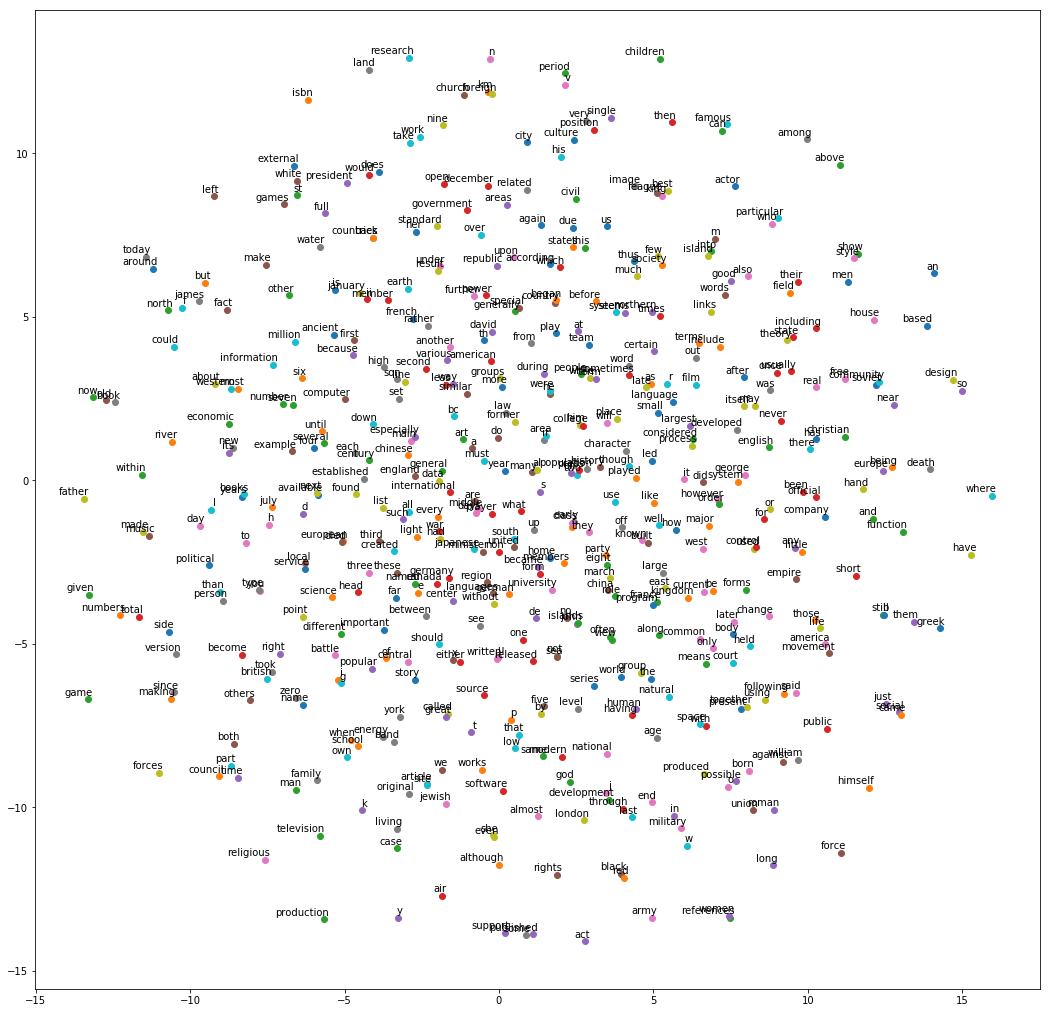

In [49]:
plot_with_labels(low_dim_embeds, labels)

In [41]:
final_embeds = np.load(
    '../TensorFlow-Bootcamp/04-Recurrent-Neural-Networks/trained_embeddings_200k_steps.npy')

In [42]:
final_embeds.shape

(50000, 150)